In [1]:
import os
import h5py
import shutil
from astropy.nddata.utils import Cutout2D
from astropy.io import fits
from astropy import table
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import (ZScaleInterval, ImageNormalize)

# Initialize hdf5 file

In [2]:
os.path.expandvars("$SLURM_TMPDIR")

'/localscratch/anahoban.1486977.0'

In [3]:
hf = h5py.File("cutouts_filtered_128.h5", "r")
hf.close()

OSError: Unable to open file (truncated file: eof = 115963895808, sblock->base_addr = 0, stored_eof = 433846588752)

In [4]:
src = os.path.expandvars("$SCRATCH") + "/cutouts_filtered_128.h5"
dest = os.path.expandvars("$SLURM_TMPDIR") + "/"
shutil.copy2(src, dest)

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/anahoban/cutouts_filtered_128.h5'

In [ ]:
hf = h5py.File(dest + "cutouts_filtered_128.h5", "r+")
image_dir = "/home/anahoban/projects/rrg-kyi/astro/cfis/W3/"

In [ ]:
# Only use tiles with all five channels

tile_list = open(image_dir + "tiles.list", "r")

u_images = []
u_weights = []
g_images = []
g_weights = []
r_images = []
r_weights = []
i_images= []
i_weights = []
z_images = []
z_weights = []
cats = []

for tile in tile_list:
    tile = tile[:-1] # Remove new line character
    channels = tile.split(" ")
    if len(channels) == 5: # Order is u,g,r,i,z
        u_images.append(image_dir + channels[0] + ".fits")
        u_weights.append(image_dir + channels[0] + ".weight.fits.fz")
        g_images.append(image_dir + channels[1] + ".fits")
        g_weights.append(image_dir + channels[1] + ".wt.fits")
        r_images.append(image_dir + channels[2] + ".fits")
        r_weights.append(image_dir + channels[2] + ".weight.fits.fz")
        i_images.append(image_dir + channels[3] + ".fits")
        i_weights.append(image_dir + channels[3] + ".wt.fits")
        z_images.append(image_dir + channels[4] + ".fits")
        z_weights.append(image_dir + channels[4] + ".wt.fits")
        cats.append(image_dir + channels[2] + ".cat")
tile_list.close()

In [ ]:
print(len(u_images))
print(len(u_weights))
print(len(g_images))
print(len(g_weights))
print(len(r_images))
print(len(r_weights))
print(len(i_images))
print(len(i_weights))
print(len(z_images))
print(len(z_weights))
print(len(cats))

In [ ]:
# Copy tiles to $SLURM_TMPDIR
start = 0
end = 20
for n in range(start, end):
    shutil.copy2(u_images[n], dest)
    shutil.copy2(u_weights[n], dest)
    shutil.copy2(g_images[n], dest)
    shutil.copy2(g_weights[n], dest)
    shutil.copy2(r_images[n], dest)
    shutil.copy2(r_weights[n], dest)
    shutil.copy2(i_images[n], dest)
    shutil.copy2(i_weights[n], dest)
    shutil.copy2(z_images[n], dest)
    shutil.copy2(z_weights[n], dest)
    shutil.copy2(cats[n], dest)
    
    u_images[n] = os.path.abspath(dest + os.path.basename(u_images[n]))
    u_weights[n] = os.path.abspath(dest + os.path.basename(u_weights[n]))
    g_images[n] = os.path.abspath(dest + os.path.basename(g_images[n]))
    g_weights[n] = os.path.abspath(dest + os.path.basename(g_weights[n]))
    r_images[n] = os.path.abspath(dest + os.path.basename(r_images[n]))
    r_weights[n] = os.path.abspath(dest + os.path.basename(r_weights[n]))
    i_images[n] = os.path.abspath(dest + os.path.basename(i_images[n]))
    i_weights[n] = os.path.abspath(dest + os.path.basename(i_weights[n]))
    z_images[n] = os.path.abspath(dest + os.path.basename(z_images[n]))
    z_weights[n] = os.path.abspath(dest + os.path.basename(z_weights[n]))    
    cats[n] = os.path.abspath(dest + os.path.basename(cats[n]))

# Store cutouts into hdf5 file

In [ ]:
def create_cutouts(img, wt, x, y, band):
    img_cutout = Cutout2D(img.data, (x, y), cutout_size, mode="partial", fill_value=0).data
    if np.count_nonzero(np.isnan(img_cutout)) >= 0.05*cutout_size**2 or np.count_nonzero(img_cutout) == 0: # Don't use this cutout
        return (None, None)
    wt_cutout = Cutout2D(wt.data, (x, y), cutout_size, mode="partial", fill_value=0).data
    img_cutout[np.isnan(img_cutout)] = 0
    wt_cutout[np.isnan(wt_cutout)] = 0
    
    img_lower = np.percentile(img_cutout, 1)
    img_upper = np.percentile(img_cutout, 99)
    
    if img_lower == img_upper:
        img_norm = np.zeros((cutout_size, cutout_size))
    else:
        img_norm = (img_cutout - np.min(img_cutout)) / (img_upper - img_lower)
    if (band != "u" or band != "r") and img_upper != img_lower: # Alter weights for PS1
        wt_norm = (wt_cutout - np.min(wt_cutout)) / (img_upper - img_lower)
    else: # Do not alter weights for CFIS
        wt_norm = wt_cutout
        
    return (img_norm, wt_norm)

In [ ]:
cutout_size = 128
img_cutout = np.zeros((cutout_size, cutout_size, 5))
wt_cutout = np.zeros((cutout_size, cutout_size, 5))
for n in range(start, end):
    root = os.path.basename(u_images[n])[5:12] + "/" # XXX.XXX id
    
    u_image = fits.open(u_images[n], memmap=True)
    u_weight = fits.open(u_weights[n], memmap=True)
    g_image = fits.open(g_images[n], memmap=True)
    g_weight = fits.open(g_weights[n], memmap=True)
    r_image = fits.open(r_images[n], memmap=True)
    r_weight = fits.open(r_weights[n], memmap=True)
    i_image = fits.open(i_images[n], memmap=True)
    i_weight = fits.open(i_weights[n], memmap=True)
    z_image = fits.open(z_images[n], memmap=True)
    z_weight = fits.open(z_weights[n], memmap=True)
    cat = table.Table.read(cats[n], format="ascii.sextractor")
    
    img_group = hf.create_group(root + "IMAGES")
    wt_group = hf.create_group(root + "WEIGHTS")

    count = 0
    for i in range(len(cat)):
        if cat["FLAGS"][i] != 0 or cat["MAG_AUTO"][i] >= 99.0 or cat["MAGERR_AUTO"][i] <= 0 or cat["MAGERR_AUTO"][i] >= 1:
            continue
        x = cat["X_IMAGE"][i]
        y = cat["Y_IMAGE"][i]
        (r_img, r_wt) = create_cutouts(r_image[0], r_weight[1], x, y, "r")
        if r_img is None:
            continue
        (u_img, u_wt) = create_cutouts(u_image[0], u_weight[1], x, y, "u")
        if u_img is None:
            continue
        (g_img, g_wt) = create_cutouts(g_image[0], g_weight[0], x, y, "g")
        if g_img is None:
            continue
        (i_img, i_wt) = create_cutouts(i_image[0], i_weight[0], x, y, "i")
        if i_img is None:
            continue
        (z_img, z_wt) = create_cutouts(z_image[0], z_weight[0], x, y, "z")
        if z_img is None:
            continue
        
        img_cutout[:,:,0] = u_img
        img_cutout[:,:,1] = g_img
        img_cutout[:,:,2] = r_img
        img_cutout[:,:,3] = i_img
        img_cutout[:,:,4] = z_img
        wt_cutout[:,:,0] = u_wt
        wt_cutout[:,:,1] = g_wt
        wt_cutout[:,:,2] = r_wt
        wt_cutout[:,:,3] = i_wt
        wt_cutout[:,:,4] = z_wt

        img_group.create_dataset(f"c{count}", data=img_cutout)
        wt_group.create_dataset(f"c{count}", data=wt_cutout)
        count += 1
    
    u_image.close()
    u_weight.close()
    g_image.close()
    g_weight.close()
    r_image.close()
    r_weight.close()
    i_image.close()
    i_weight.close()
    z_image.close()
    z_weight.close()
    print(f"Tile {n+1} completed")

# Test getting and plotting cutouts from hdf5 file

In [5]:
group = hf.get("180.272/IMAGES")
plot_cutouts = np.array(group.get("c110"))
print(plot_cutouts.shape)

NameError: name 'hf' is not defined

NameError: name 'plot_cutouts' is not defined

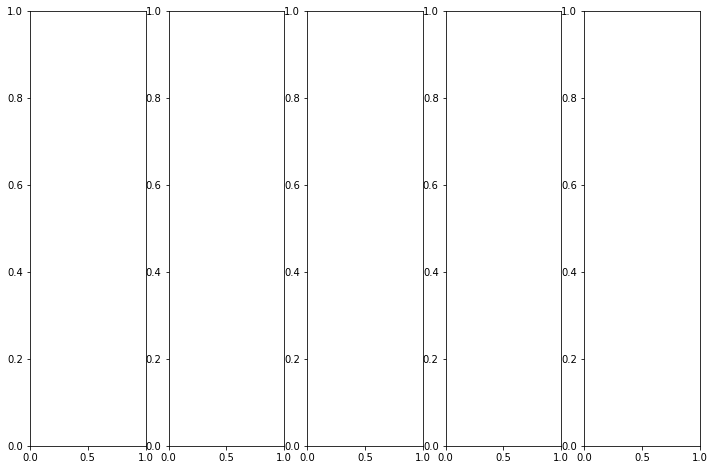

In [6]:
channels = ["u", "g", "r", "i", "z"]
fig, axes = plt.subplots(1,5, figsize=(12,8))
for i in range(5):
    norm = ImageNormalize(plot_cutouts[:,:,i], interval=ZScaleInterval())
    axes[i].imshow(plot_cutouts[:,:,i], norm=norm)
    axes[i].set_title(channels[i])

In [ ]:
group_weight = hf.get("180.272/WEIGHTS")
plot_weights = np.array(group_weight.get("c110"))
print(plot_weights.shape)

In [ ]:
channels = ["u", "g", "r", "i", "z"]
fig, axes = plt.subplots(1,5, figsize=(12,8))
for i in range(5):
    norm = ImageNormalize(plot_weights[:,:,i], interval=ZScaleInterval())
    axes[i].imshow(plot_weights[:,:,i], norm=norm)
    axes[i].set_title(channels[i])

In [ ]:
hf.close()

hf.close()
src = os.path.expandvars("$SLURM_TMPDIR") + "/cutouts_filtered_128.h5"
dest = os.path.expandvars("$SCRATCH") + "/"
shutil.copy2(src, dest)